In [1]:
import math
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from datetime import timedelta

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from custom_transforms.transforms import *

2024-03-21 18:49:48.895817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 18:49:49.772795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')
filtered_alface_crespa_roca.index = filtered_alface_crespa_roca.index.tz_localize("UTC")
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca["first_day_week"] = filtered_alface_crespa_roca.index - filtered_alface_crespa_roca.index.weekday * timedelta(days=1)

In [3]:
weather_df = pd.read_csv('../processed_data/weather_2016_2023.csv', index_col=0)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
for col in weather_df.columns:
    weather_df[col] = weather_df[col].replace(-9999, None)
weather_df = weather_df[(weather_df.index >= '2016-04-24') & (weather_df.index <= '2023-09-24')]
weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())



weather_weekly_df["first_day_week"] = (weather_weekly_df.index - weather_weekly_df.index.weekday * timedelta(days=1))

In [4]:
#weather_weekly_df['RADIAÇÃO GLOBAL (Kj/m²)'] = weather_df['RADIACAO GLOBAL (Kj/m²)'].resample('W').max()
weather_weekly_df['RADIACAO GLOBAL (Kj/m²)']=weather_df['RADIACAO GLOBAL (Kj/m²)'].resample('W').max()

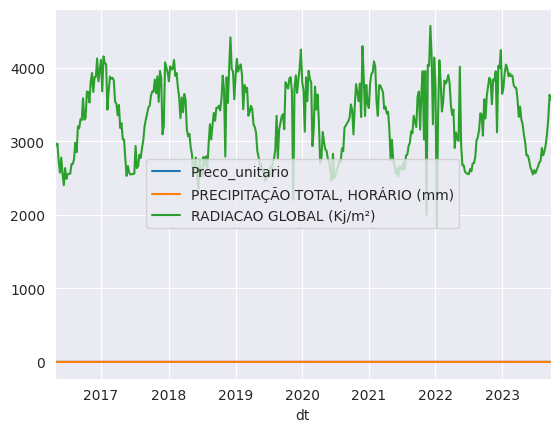

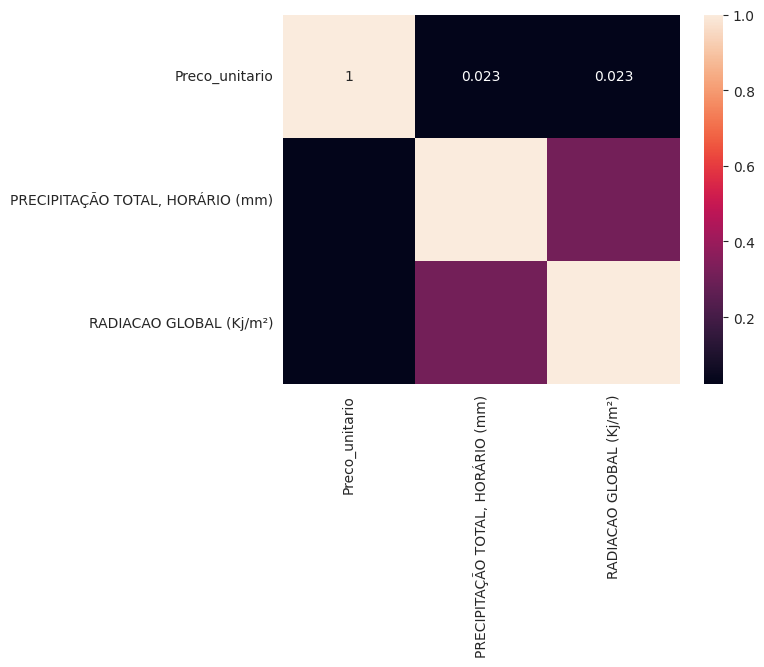

In [5]:
price_weather_df = pd.merge(filtered_alface_crespa_roca, weather_weekly_df, on='first_day_week', how='left')
price_weather_df.index = filtered_alface_crespa_roca.index

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()
plt.show()
sns.heatmap(price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].corr(), annot=True)
plt.show()

In [6]:
def input_output_split(data, in_size, out_size):
	#split into input and output
	train_X, train_Y = data.values[:, :-out_size], data.values[:, -out_size:]
	return train_X, train_Y


In [7]:
def train_test_validation_split(data, train_percentage, test_percentage):
	dataset_size = len(data)
	train_size = math.ceil(dataset_size * train_percentage)
	test_size = math.ceil(dataset_size * test_percentage)
	validation_size = dataset_size - train_size - test_size
	print(f"train_size: {train_size}\nvalidation_size: {validation_size}\ntest_size: {test_size}")
	
	train = data[0:train_size]
	validation = data[train_size:train_size + validation_size]
	test = data[train_size + validation_size:dataset_size]
	print(
	f"values_train: {train.shape}\nvalues_validation: {validation.shape}\nvalues_test: {test.shape}")
	#print final percentages
	train_percentage = len(train) / dataset_size
	validation_percentage = len(validation) / dataset_size
	test_percentage = len(test) / dataset_size
	print(f"train_percentage: {train_percentage}\nvalidation_percentage: {validation_percentage}\ntest_percentage: {test_percentage}")
	return train, validation, test


In [8]:
train, valid, test = train_test_validation_split(price_weather_df, 0.7, 0.2)
train_index, valid_index, test_index = train.index, valid.index, test.index

train_size: 272
validation_size: 38
test_size: 78
values_train: (272, 4)
values_validation: (38, 4)
values_test: (78, 4)
train_percentage: 0.7010309278350515
validation_percentage: 0.0979381443298969
test_percentage: 0.20103092783505155


In [9]:
in_size = 8
out_size = 8
keep_only_size = 8

input_columns = ['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
n_vars = len(input_columns)
scaler = MinMaxScaler(feature_range=(0, 1))
column_selector = ColumnSelector(input_columns) 
reframer = Reframer(n_in=in_size, n_out=out_size)
drop_cols = DropColumns(n_in=in_size, n_out=out_size, n_vars=n_vars)

preprocess_pipeline = Pipeline(
	[
		('column_selector', column_selector),
		('scaler', scaler), 
		('reframer', reframer), 
		('drop_cols', drop_cols)
	 ]
)


In [10]:
preprocessed_train = preprocess_pipeline.fit_transform(train)
preprocessed_valid = preprocess_pipeline.transform(valid)
preprocessed_test = preprocess_pipeline.transform(test)

train_X, train_Y = input_output_split(preprocessed_train, in_size, keep_only_size)
validation_X, validation_Y = input_output_split(preprocessed_valid, in_size, keep_only_size)
test_X, test_Y = input_output_split(preprocessed_test, in_size, keep_only_size)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)


(257, 1, 16) (257, 8) (63, 1, 16) (63, 8)


2024-03-21 18:49:52.296894: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/100
4/4 - 2s - loss: 0.0969 - val_loss: 0.5030 - 2s/epoch - 435ms/step
Epoch 2/100
4/4 - 0s - loss: 0.0781 - val_loss: 0.4472 - 38ms/epoch - 9ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0613 - val_loss: 0.3910 - 41ms/epoch - 10ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0466 - val_loss: 0.3351 - 44ms/epoch - 11ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0360 - val_loss: 0.2829 - 38ms/epoch - 9ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0294 - val_loss: 0.2401 - 40ms/epoch - 10ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0276 - val_loss: 0.2121 - 37ms/epoch - 9ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0285 - val_loss: 0.2010 - 43ms/epoch - 11ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0287 - val_loss: 0.2033 - 42ms/epoch - 11ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0284 - val_loss: 0.2134 - 39ms/epoch - 10ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0266 - val_loss: 0.2253 - 38ms/epoch - 10ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0259 - val_loss: 0.2356 - 37ms/epoch - 9ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0254 - val

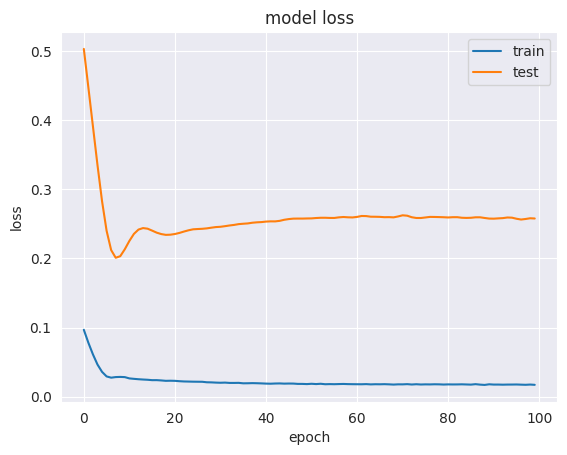

In [11]:

model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(keep_only_size))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=70, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

2/2 [==============================] - 0s 3ms/step
Test RMSE: 0.409
63
63
63
63
63
63
63
63


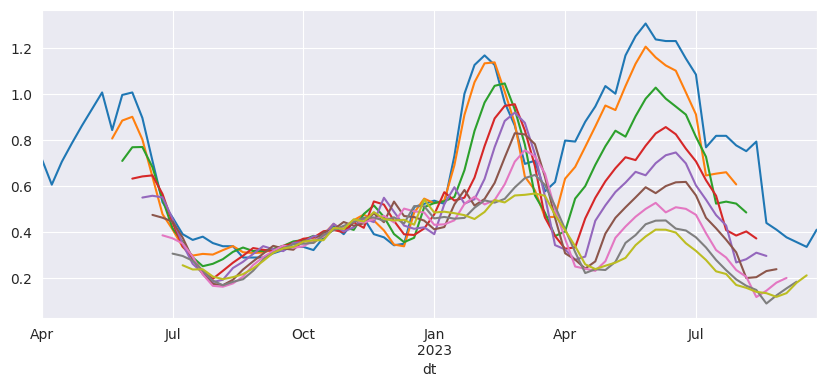

In [12]:
# make a prediction
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], 16))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
print('Test RMSE: %.3f' % rmse)

normalized_test = preprocess_pipeline[:-2].transform(test)
test_price = normalized_test[:,0]
test_series = pd.Series(test_price, index=test_index)
plt.figure(figsize=(10, 4))
test['Preco_unitario'].plot(label="actual_norm")
rmses_list = []

for i in range(keep_only_size):
	pred = yhat[:,i]#, index=test_index[jump:len(yhat)+jump])
	print(len(pred))
	jump = in_size + i -1
	reconstituted_set = pd.DataFrame(
		{"Preco_unitario": pred, "2": list(len(pred)*[0])}, index=test_index[jump:len(yhat)+jump])
	
	rmses_list.append(np.sqrt(mean_squared_error(test_series[jump:len(pred)+jump], pred)))
	de_normalized = pd.Series(preprocess_pipeline[1].inverse_transform(reconstituted_set)[:,0], index=test_index[jump:len(yhat)+jump])
	de_normalized.plot()


plt.show()


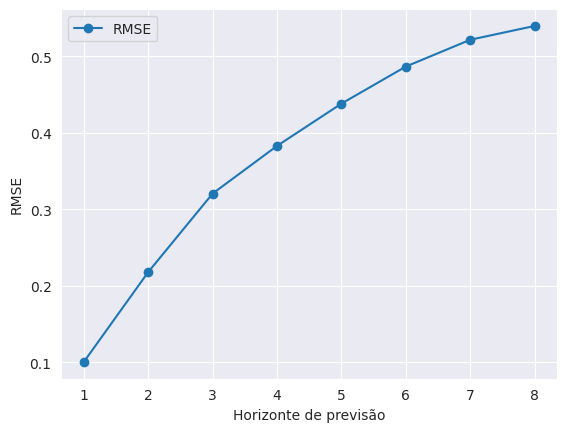

In [13]:
rmses = pd.DataFrame(rmses_list, index=[i+1 for i in range(keep_only_size)], columns=['RMSE'])
rmses.plot(marker='o')
plt.xlabel('Horizonte de previsão')
plt.ylabel('RMSE')
plt.show()
